### Importing Required Libraries and Modules

In [3]:
import numpy as np
import cv2
import os
import csv
import datetime
import time
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

### Dataset Generation and Face Cropping from Webcam

In [5]:
def generate_dataset():
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    
    if face_classifier.empty():
        print("Error: Could not load face cascade classifier.")
        return

    def face_cropped(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_classifier.detectMultiScale(gray, 1.3, 5)
        
        if len(faces) == 0:  
            return None
        
        for (x, y, w, h) in faces:
            cropped_face = img[y:y+h, x:x+w]
            return cropped_face
    
    cap = cv2.VideoCapture(0)  
    
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return
    
    user_id = input("Enter user ID (name): ")
    dataset_dir = "data"
    
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir)

    img_id = 0
    print("Press 'Enter' to capture images or 'Esc' to exit...")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame from webcam.")
            break
        
        face = face_cropped(frame)
        if face is not None:
            img_id += 1
            face_resized = cv2.resize(face, (200, 200))
            face_gray = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)
            
            file_name_path = os.path.join(dataset_dir, f"{user_id}_{img_id}.jpg")
            cv2.imwrite(file_name_path, face_gray)
            
            cv2.putText(face_gray, str(img_id), (50, 50), cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0), 2)
            cv2.imshow("Cropped Face", face_gray)

        key = cv2.waitKey(1)
        if key == 13:  
            print("Capturing stopped by user.")
            break
        elif key == 27:  
            print("Exiting...")
            break

        if img_id >= 3000:
            print("Maximum samples collected (3000 images).")
            break

    cap.release()
    cv2.destroyAllWindows()
    print("Collecting samples is completed....")

generate_dataset()

Enter user ID (name):  Nishchal


Press 'Enter' to capture images or 'Esc' to exit...
Capturing stopped by user.


### Data Labeling and Preprocessing for Face Recognition Model

In [12]:
def my_label(img_filename):
    name = img_filename.split('_')[0]  
    
    if name == "Nishchal":
        return np.array([1, 0, 0])
    elif name == "Sishir":
        return np.array([0, 1, 0])
    elif name == "Roshan":
        return np.array([0, 0, 1])
    else:
        return np.array([0, 0, 0])  


def my_data():
    data = []
    
    for img in tqdm(os.listdir("data")):
        img_path = os.path.join("data", img)
        img_data = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
        img_data = cv2.resize(img_data, (50, 50))  
        
        data.append([np.array(img_data), my_label(img)])

    shuffle(data)
    return data

data = my_data()

split_index = int(0.8 * len(data))
train = data[:split_index]
test = data[split_index:]

X_train = np.array([i[0] for i in train]).reshape(-1, 50, 50, 1)
X_test = np.array([i[0] for i in test]).reshape(-1, 50, 50, 1)

y_train = np.array([i[1] for i in train])
y_test = np.array([i[1] for i in test])

num_classes = y_train.shape[1]  
y_train = to_categorical([np.argmax(label) for label in y_train], num_classes=num_classes)
y_test = to_categorical([np.argmax(label) for label in y_test], num_classes=num_classes)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


100%|██████████| 9010/9010 [00:05<00:00, 1661.72it/s]

X_train shape: (7208, 50, 50, 1)
y_train shape: (7208, 3)
X_test shape: (1802, 50, 50, 1)
y_test shape: (1802, 3)


### Loading and Training Face Recognition Model Using CNN

In [17]:
def load_data(dataset_dir="data"):
    data = []
    labels = []
    user_ids = [] 
    
    for file in os.listdir(dataset_dir):
        if file.endswith(".jpg"):
            path = os.path.join(dataset_dir, file)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  
            
            
            img_resized = cv2.resize(img, (50, 50))
            data.append(np.array(img_resized))
            
            user_id = file.split("_")[0]
            
            if user_id not in user_ids:
                user_ids.append(user_id)  
            labels.append(user_ids.index(user_id))  
    
    
    data = np.array(data).reshape(-1, 50, 50, 1)  
    labels = np.array(labels)

    data = data / 255.0
    
    return data, labels, user_ids

X, y, user_ids = load_data()

y = to_categorical(y, num_classes=len(user_ids))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data loaded: {X_train.shape[0]} training samples, {X_test.shape[0]} testing samples.")

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(user_ids), activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

model.save('face_recognition_model.h5')

Data loaded: 7208 training samples, 1802 testing samples.
Epoch 1/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9326 - loss: 0.1693 - val_accuracy: 1.0000 - val_loss: 4.4455e-04
Epoch 2/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 8.9159e-04
Epoch 3/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 2.5822e-04
Epoch 4/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9991 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 7.1313e-05
Epoch 5/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 1.0000 - loss: 3.9589e-04 - val_accuracy: 1.0000 - val_loss: 4.6272e-05
Epoch 6/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9998 - loss: 3.3469e-04 - val_accuracy: 1.0000 - val_loss: 2.3846e-06
Epoch 7/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9985 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 1.1941e-04
Ep

Test accuracy: 100.00%


In [50]:
model = load_model('face_recognition_model.h5')

predictions = model.predict(X_test)

predicted_label = np.argmax(predictions[0])  
print(f"Predicted label: {predicted_label}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predicted label: 2


### Visualizing Predictions with Matplotlib

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


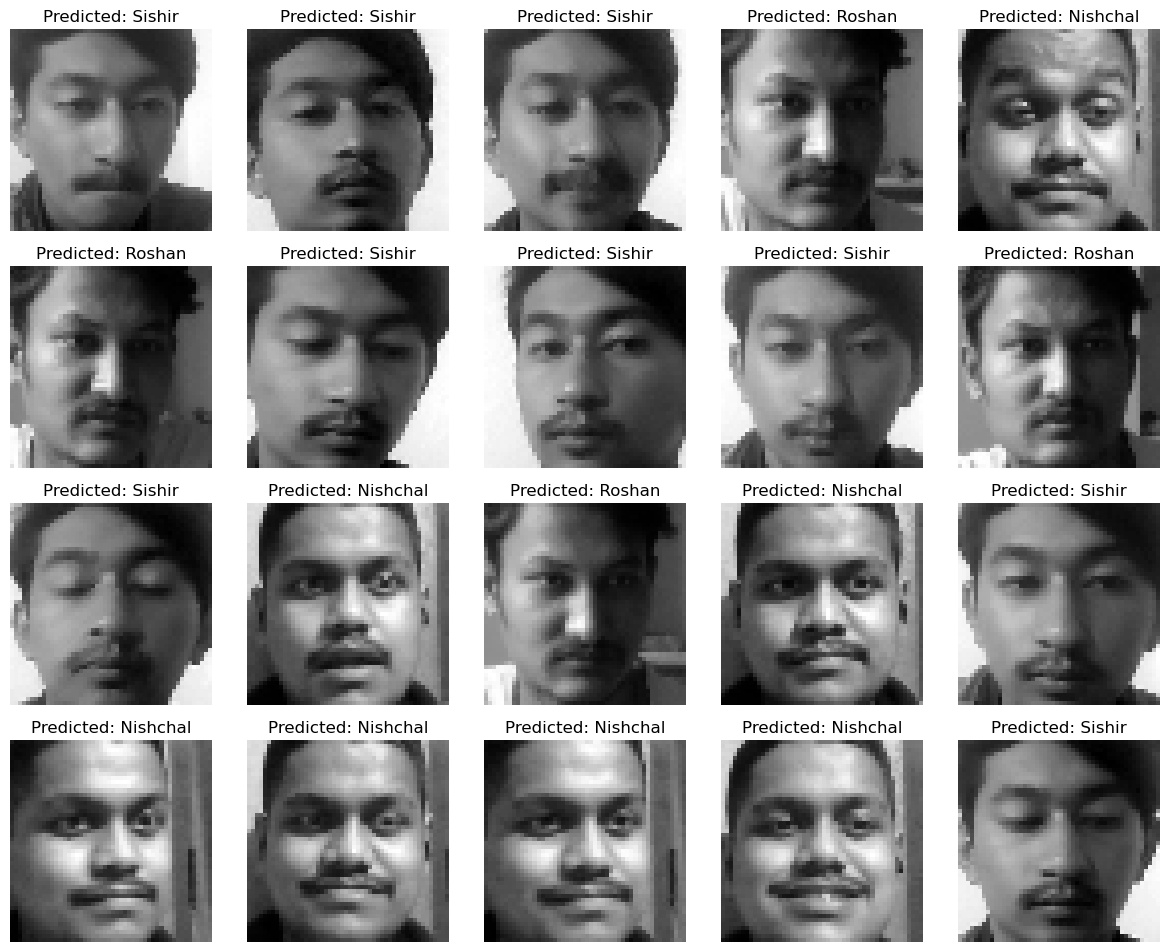

In [48]:
label_map = {0: "Nishchal", 1: "Roshan", 2: "Sishir"}


num_images_to_display = 20

predictions = model.predict(X_test)


plt.figure(figsize=(12, 12))  
for i in range(num_images_to_display):
    plt.subplot(5, 5, i + 1)  
    plt.imshow(X_test[i].reshape(50, 50), cmap='gray')  
    predicted_index = np.argmax(predictions[i])  
    predicted_label = label_map[predicted_index]  
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')  

plt.tight_layout()  
plt.show()

### Recognition and Attendance Logging

In [3]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

model = load_model('face_recognition_model.h5')

label_map = {0: "Nishchal", 1: "Roshan", 2: "Sishir"}

def preprocess_face(face_img):
    if face_img is None or face_img.size == 0:
        return None
    face_resized = cv2.resize(face_img, (50, 50))  
    face_resized = cv2.equalizeHist(face_resized)   
    face_resized = face_resized / 255.0  
    face_reshaped = np.reshape(face_resized, (1, 50, 50, 1))  
    return face_reshaped


threshold = 0.99  

attendance_file = 'attendance_log.csv'
if not os.path.exists(attendance_file):
    with open(attendance_file, mode='w') as f:
        writer = csv.writer(f)
        writer.writerow(['Name', 'Date', 'Time'])  


def log_attendance(name):
    current_time = datetime.datetime.now()
    date = current_time.date()
    time = current_time.time()

    with open(attendance_file, mode='a') as f:
        writer = csv.writer(f)
        writer.writerow([name, date, time])

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()  
    if not ret:
        break
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  
    faces = face_classifier.detectMultiScale(gray_frame, 1.3, 5)  
    
    for (x, y, w, h) in faces:
        face = gray_frame[y:y+h, x:x+w]  
        face_preprocessed = preprocess_face(face)  


        prediction = model.predict(face_preprocessed)
        confidence = np.max(prediction)  
        predicted_index = np.argmax(prediction)  
        
        
        if confidence > threshold:
            predicted_name = label_map[predicted_index]  
            log_attendance(predicted_name)  
        else:
            predicted_name = "Unknown"  

        
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, predicted_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)
    
    
    cv2.imshow('Real-Time Face Recognition', frame)
    
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 